# Google Driveをマウント

In [0]:
from google.colab import drive
drive.mount('/content/drive')

!ls drive/My\ Drive

# 作業ディレクトリに移動

In [2]:
import os
!ls drive
print(os.getcwd())
os.chdir("drive/My Drive/data/fcn")
print(os.getcwd())

'My Drive'
/content
/content/drive/My Drive/data/fcn


# SetUp

In [3]:
% matplotlib inline
import os, re, imghdr
import keras
from keras import models
from keras.layers import Conv2D, MaxPooling2D, Flatten, Activation, Dense, Dropout, BatchNormalization
from keras import optimizers
from keras.callbacks import TensorBoard, ModelCheckpoint
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np

Using TensorFlow backend.


In [4]:
!ls

data  dataloader.py  log  models.py  __pycache__  utils


In [0]:
#import my module
from dataloader import DataLoader
from models import *
from utils.list_util import list_from_dir
from utils.color import make_cmap

N_CLASS = 21
INPUT_SIZE = 224

### ディレクトリ設定

In [0]:
log_dir = "log"
os.makedirs(log_dir, exist_ok=True)

weight_path = os.path.join(log_dir, "weights.hdf5")
train_data_dir = "data/train"
val_data_dir = "data/val"

train_img_dir = os.path.join(train_data_dir, 'img')
train_gt_dir = os.path.join(train_data_dir, 'gt')
val_img_dir = os.path.join(val_data_dir, 'img')
val_gt_dir = os.path.join(val_data_dir, 'gt')

### データパス取得

In [7]:
train_data_paths = list_from_dir(train_img_dir, ('.jpg', '.png'))
train_gt_paths = list_from_dir(train_gt_dir, ('.jpg', '.png'))
val_data_paths = list_from_dir(val_img_dir, ('.jpg', '.png'))
val_gt_paths = list_from_dir(val_gt_dir, ('.jpg', '.png'))

print(len(train_data_paths))
print(len(train_gt_paths))
print(len(val_data_paths))
print(len(val_gt_paths))

1464
1464
1449
1449


# 学習

### Select model

In [8]:
model = FCN8s()
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 224, 224, 64) 1792        input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 224, 224, 64) 36928       block1_conv1[1][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 112, 112, 64) 0           block1_conv2[1][0]               
__________________________________________________________________________________________________
block2_con

### Compile

In [13]:
BATCH_SIZE = 24
EPOCHS = 100


steps_per_epoch =  len(train_data_paths) // BATCH_SIZE
validation_steps =  len(val_data_paths) // BATCH_SIZE


print("epochs : ", EPOCHS)
print("batch_size : ", BATCH_SIZE)
print("steps_per_epoch : ", steps_per_epoch)
print("validation_steps : ", validation_steps)


optimizer = optimizers.SGD(lr=0.01, momentum=0.9, nesterov=True)

model.compile(loss="categorical_crossentropy",
                            optimizer=optimizer,
                            metrics=["accuracy"])


ckpt_name = 'weights-{epoch:02d}-{loss:.2f}-{acc:.2f}-{val_loss:.2f}-{val_acc:.2f}-.hdf5'
cbs = [
    ModelCheckpoint(os.path.join(log_dir, ckpt_name),
                    monitor='val_acc', verbose=0,
                    save_best_only=True,
                    save_weights_only=True,
                    mode='auto', period=1)
]

train_loader = DataLoader(N_CLASS, input_size=INPUT_SIZE)
val_loader = DataLoader(N_CLASS, input_size=INPUT_SIZE)

epochs          :  100
batch_size      :  24
steps_per_epoch :  61
validation_steps :  60


### Training

In [14]:
# class_weighting = [0.3, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,
#                                   1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

history = model.fit_generator(
    train_loader.flow(train_data_paths, train_gt_paths, batch_size=BATCH_SIZE),
    steps_per_epoch=steps_per_epoch,
    epochs=EPOCHS,
    validation_data=val_loader.flow(val_data_paths, val_gt_paths, batch_size=BATCH_SIZE),
    validation_steps=validation_steps,
    #class_weight=class_weighting,
    verbose=1)

Epoch 1/100
61/61 [==============================] - 1400s 23s/step - loss: 2.0851 - acc: 0.5176 - val_loss: 1.9084 - val_acc: 0.5653
Epoch 2/100
61/61 [==============================] - 168s 3s/step - loss: 1.7997 - acc: 0.5718 - val_loss: 1.7928 - val_acc: 0.5668
Epoch 3/100
61/61 [==============================] - 167s 3s/step - loss: 1.7054 - acc: 0.5795 - val_loss: 1.7018 - val_acc: 0.5721
Epoch 4/100
61/61 [==============================] - 167s 3s/step - loss: 1.6421 - acc: 0.5864 - val_loss: 1.6701 - val_acc: 0.5814
Epoch 5/100
61/61 [==============================] - 167s 3s/step - loss: 1.6046 - acc: 0.5948 - val_loss: 1.6134 - val_acc: 0.5872
Epoch 6/100
61/61 [==============================] - 168s 3s/step - loss: 1.5705 - acc: 0.5976 - val_loss: 1.5890 - val_acc: 0.5866
Epoch 7/100
61/61 [==============================] - 167s 3s/step - loss: 1.5392 - acc: 0.6078 - val_loss: 1.7012 - val_acc: 0.5880
Epoch 8/100
61/61 [==============================] - 167s 3s/step - loss: 

### Save weights

In [0]:
model.save_weights(weight_path)

### Training accuracy

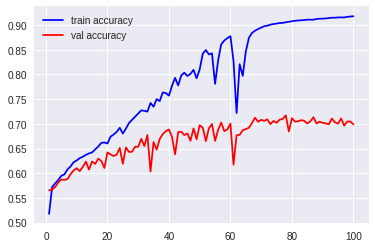

In [20]:
acc = history.history['acc']
val_acc = history.history['val_acc']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'b', label='train accuracy')
plt.plot(epochs, val_acc, 'r', label='val accuracy')
plt.legend()
plt.show()

### Training loss

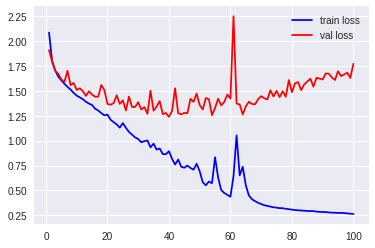

In [21]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, loss, 'b', label='train loss')
plt.plot(epochs, val_loss, 'r', label='val loss')

plt.legend()
plt.show()

# 予測

In [0]:
def pred_to_img(pred):
    cmap = make_cmap()

    pred_ = np.argmax(pred[0], axis=2)
    row, col = pred_.shape
    dst = np.ones((row, col, 3))
    for i in range(21):
        dst[pred_ == i] = cmap[i]

    return np.uint8(dst)

### Load weights

In [23]:
model = FCN8s()
print('load weight : ', weight_path)
model.load_weights(weight_path)

load weight :  log/weights.hdf5


### Prediction

In [42]:
img_idx = 71


eval_loader = DataLoader(N_CLASS, INPUT_SIZE)

#---------------------------
# Select test image
#---------------------------
input_img_path = val_data_paths[img_idx]
gt_img_path = val_gt_paths[img_idx]

#---------------------------
# Load test image
#---------------------------
input_img = eval_loader.load_data(input_img_path)
gt_img = eval_loader.load_data(gt_img_path, label_data=True)

#---------------------------
# Output prediction
#---------------------------
pred = model.predict(input_img)

print(pred.shape)

(1, 224, 224, 21)


### Show result image

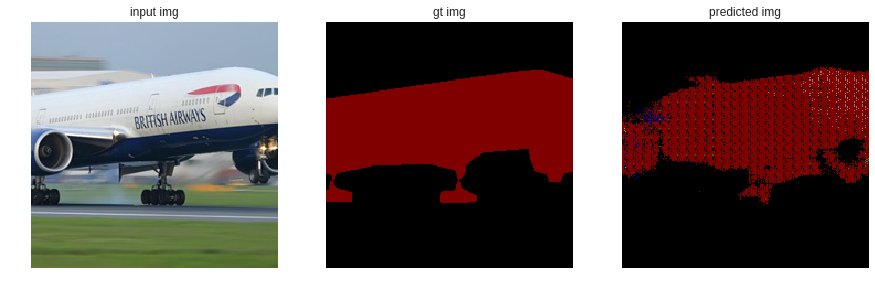

In [43]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

#---------------------------
# Show original image
#---------------------------
# im = Image.open(input_img_path)
# im = np.asarray(im)
# plt.imshow(im)
# plt.show()

#---------------------------
# Input img
#---------------------------
input_img_ = (input_img[0] + 1) * 127.5
input_img_ = np.uint8(input_img_)

#---------------------------
# GT img
#---------------------------
gt_img_ = pred_to_img(gt_img)

#---------------------------
# Prediction img
#---------------------------
predicted_img = pred_to_img(pred)

#---------------------------
# Show imgs
#---------------------------
plt.figure(figsize=(15,15))
img_list = [input_img_, gt_img_, predicted_img]
titel_list = ["input img", "gt img", "predicted img"]
plot_num = 1
for title, img in zip(titel_list, img_list):
    plt.subplot(1,3, plot_num)
    plt.title(title)
    plt.axis("off")
    plt.imshow(img)
    plot_num += 1

plt.show()